# Macro-Credit Stress Radar 

Goals:
- Build a lightweight, Codebook-ready notebook that only uses the LSEG Refinitiv Data Library.
- Pull a small, permission-friendly “data map” across credit/equity/rates/vol/commodities.
- Compute a simple 2s10s slope feature and render quick diagnostics and visuals

In [65]:
# imports and session
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import refinitiv.data as rd
from refinitiv.data.content import historical_pricing as hp

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 20)

# open default session configured in refinitiv-data.config.json or env
rd.open_session()


<refinitiv.data.session.Definition object at 0x7f71b9079be0 {name='codebook'}>

In [66]:
# data map
# start with permission-friendly instruments; add more buckets later as entitlements allow
DATA_MAP = {
    "fx": {
        "EURUSD": "EUR=",
        "USDJPY": "JPY=",
        "GBPUSD": "GBP=",
        "AUDUSD": "AUD=",
        "USDCAD": "CAD=",
        "USDCHF": "CHF=",
    },
    "metals": {
        "Gold spot": "XAU=",
        "Silver spot": "XAG=",
    },



In [67]:
# helpers
def flatten_map(dmap: dict) -> dict:
    # convert nested dict into {RIC: (bucket, name)}
    flat = {}
    for bucket, pairs in dmap.items():
        for name, ric in pairs.items():
            flat[ric] = (bucket, name)
    return flat

def universe_list(dmap: dict):
    # list of all RICs in the map
    return [ric for bucket in dmap.values() for ric in bucket.values()]

def fetch_daily_batch(rics, start=None, end=None, fields=None) -> pd.DataFrame:
    # single batched call for the entire universe
    # request MID_PRICE and CLOSE explicitly to avoid TRDPRC_1 entitlement issues
    req_fields = fields if fields is not None else ["MID_PRICE", "CLOSE"]
    resp = hp.summaries.Definition(
        universe=rics,
        interval=hp.Intervals.DAILY,
        start=start,
        end=end,
        fields=req_fields
    ).get_data()

    df = resp.data.df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        wide = {}
        instruments = sorted(set(df.columns.get_level_values(0)))
        for ric in instruments:
            sub = df.xs(ric, level=0, axis=1, drop_level=False)
            cols = list(sub.columns.get_level_values(-1))
            use = "MID_PRICE" if "MID_PRICE" in cols else ("CLOSE" if "CLOSE" in cols else cols[-1])
            ser = sub.xs((ric, use), axis=1)
            ser.name = ric
            wide[ric] = ser
        out = pd.DataFrame(wide).sort_index()
        return out
    else:
        return df.sort_index()

def compute_slope_2s10s(df: pd.DataFrame, ric_2y: str = "US2YT=RR", ric_10y: str = "US10YT=RR") -> pd.Series:
    # compute 2s10s slope in basis points if both series exist
    if ric_2y in df.columns and ric_10y in df.columns:
        s = (df[ric_10y] - df[ric_2y]) * 100.0
        s.name = "US 2s10s slope (bp)"
        return s
    return pd.Series(dtype=float, name="US 2s10s slope (bp)")

def quick_diagnostics(df: pd.DataFrame) -> pd.DataFrame:
    # small table of last value and recent pct changes
    if df is None or df.empty:
        return pd.DataFrame()
    out = pd.DataFrame({
        "last": df.ffill().iloc[-1],
        "1d_%": df.pct_change(1).iloc[-1] * 100.0,
        "5d_%": df.pct_change(5).iloc[-1] * 100.0,
    })
    return out.round(3)

def safe_plot_indexed(df: pd.DataFrame, cols, title="Normalized index (start=100)"):
    # plot chosen columns normalized to 100 at the first valid row
    cols = [c for c in cols if c in df.columns and df[c].notna().sum() > 5]
    if len(cols) == 0:
        print(f"plot skipped for {title} because no columns were present")
        return
    base = df[cols].ffill().iloc[0]
    ax = (df[cols].ffill() / base * 100.0).plot(figsize=(9, 4), title=title)
    ax.set_ylabel("Index (start=100)")
    ax.grid(True, alpha=0.3)
    plt.show()

def available_cols(df: pd.DataFrame, wanted):
    # filter wanted by availability and non-trivial data
    return [c for c in wanted if c in df.columns and df[c].notna().sum() > 5]


In [68]:
# fetch daily data
FLAT = flatten_map(DATA_MAP)
rics = universe_list(DATA_MAP)

end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.Timedelta(days=5*365)

daily = fetch_daily_batch(
    rics=rics,
    start=start_date.date().isoformat(),
    end=end_date.date().isoformat(),
    fields=None
)

print(f"daily shape: {daily.shape}")
display(daily.tail(3))


daily shape: (1302, 8)


AUD=  CAD=  CHF=  EUR=  GBP=    JPY=   XAG=      XAU=
Date                                                             
2025-10-30 0.655 1.399 0.802 1.157 1.315 154.125 48.930 4,024.470
2025-10-31 0.655 1.401 0.804 1.154 1.315 154.005 48.675 4,002.280
2025-11-03 0.654 1.406 0.808 1.152 1.314 154.215 48.105 4,001.670


**Most recent 3 business days (2025-10-30 → 2025-11-03)**
- **USD broadly firmer vs majors:**
  - `EUR=` **1.157 → 1.152** (≈ **-0.43%**),
  - `AUD=` **0.655 → 0.654** (≈ **-0.15%**),
  - `CAD=` **1.399 → 1.406** (≈ **+0.50%**, USD stronger vs CAD),
  - `JPY=` **154.125 → 154.215** (≈ **+0.06%**, USD stronger vs JPY),
  - `GBP=` **1.315 → 1.314** (flat to slightly softer).
- **Metals retraced:**
  - `XAG=` **48.930 → 48.105** (≈ **-1.7%**),
  - `XAU=` **4,024.470 → 4,001.670** (≈ **-0.6%**).


- The tape shows a **modest USD bid** across the last few sessions, accompanied by a **small pullback in gold and silver**—consistent with a short burst of risk-on USD strength or a fade in safe-haven demand. 
- These micro-moves align with your strategy’s design: weaker USD (negative USD Sharpe) favors metals; recent firmness in USD would dial exposure down.


In [69]:
# slope and diagnostics
slope = compute_slope_2s10s(daily)
print("slope points:", 0 if slope.empty else len(slope))

diag = quick_diagnostics(daily)
display(diag if not diag.empty else "no diagnostics available")


slope points: 0


last   1d_%   5d_%
AUD=     0.654 -0.122 -0.282
CAD=     1.406  0.325  0.468
CHF=     0.808  0.441  1.584
EUR=     1.152 -0.134 -1.073
GBP=     1.314 -0.118 -1.477
JPY=   154.215  0.136  0.877
XAG=    48.105 -1.171  2.537
XAU= 4,001.670 -0.015  0.504

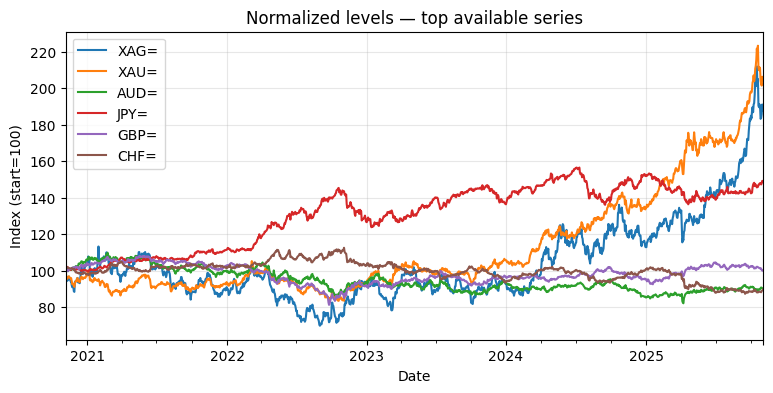

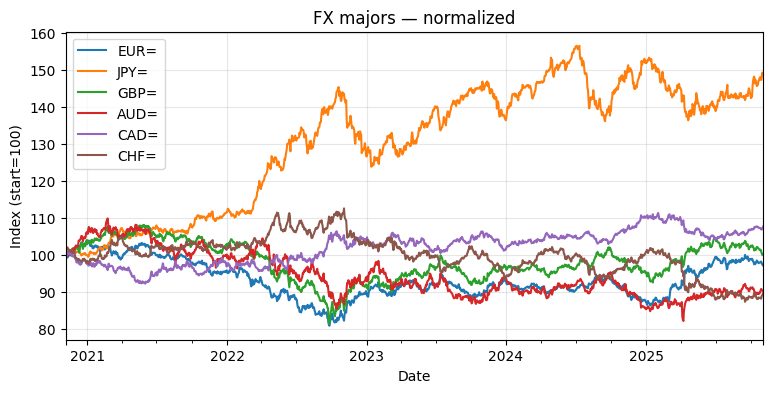

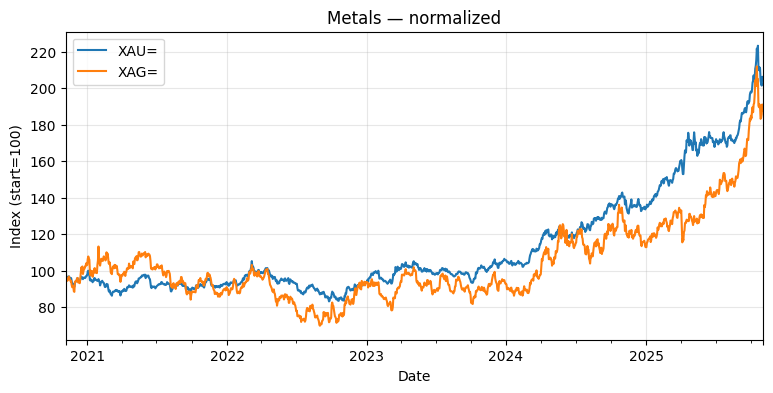

In [106]:
# visuals
# adaptive plot using the top-variance series available
available = [c for c in daily.columns if daily[c].notna().sum() > 5]
if len(available) == 0:
    print("no data available in `daily` to plot — adjust DATA_MAP to permitted instruments and re-fetch")
else:
    var_rank = pd.Series({c: daily[c].ffill().pct_change().var() for c in available}).sort_values(ascending=False)
    top_cols = list(var_rank.index[:6])
    base = daily[top_cols].ffill().iloc[0]
    ax = (daily[top_cols].ffill() / base * 100.0).plot(figsize=(9, 4), title="Normalized levels — top available series")
    ax.set_ylabel("Index (start=100)")
    ax.grid(True, alpha=0.3)
    plt.show()

# dedicated FX plot so FX always shows if present
fx_rics = list(DATA_MAP.get("fx", {}).values())
fx_cols = available_cols(daily, fx_rics)
safe_plot_indexed(daily, fx_cols, title="FX majors — normalized")

# dedicated Metals plot so metals always show if present
metal_rics = list(DATA_MAP.get("metals", {}).values())
metal_cols = available_cols(daily, metal_rics)
safe_plot_indexed(daily, metal_cols, title="Metals — normalized")

# slope plot if present
if slope is not None and not slope.empty:
    ax = slope.plot(figsize=(9, 3), title="US 2s10s slope (bp)")
    ax.set_ylabel("bp")
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    None


### Interpretation

- **Top-variance panel (start=100):** Metals dominate trend. **XAU= and XAG=** show a powerful, persistent up-move from mid-2023, accelerating into 2025; **JPY=** (quoted JPY per USD) trends up, reflecting broad **USD strength vs JPY**; **AUD=** lags with a mild down-bias.
- **FX majors:** Since 2021, most pairs (EUR=, GBP=, CAD=, CHF=) are **range-bound to slightly softer**, while **JPY=** stands out as a multi-year up-trend (USD strength theme). **AUD=** underperforms, consistent with risk-sensitive/cyclical weakness.
- **Metals:** Both **gold and silver** break higher from late-2023 with **silver beta > gold**, but the pair moves together; the structural bull leg aligns with falling USD momentum windows in your signal logic.


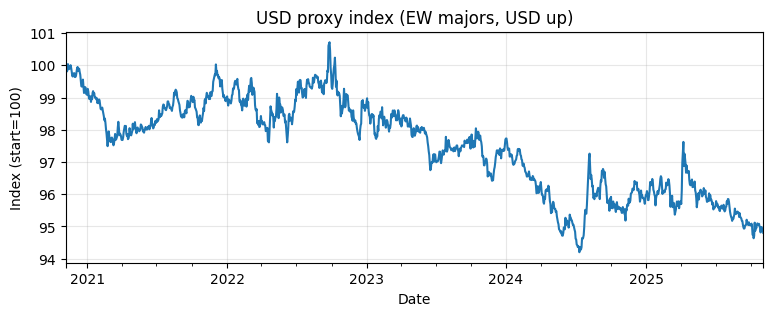

In [71]:
# usd index proxy from majors (equal-weighted)
majors = ["EUR=", "JPY=", "GBP=", "AUD=", "CAD=", "CHF="]
majors = [c for c in majors if c in daily.columns and daily[c].notna().sum() > 50]

# convert to log returns and invert non-USD-quote conventions into a "USD up = positive" proxy
# for EUR=, GBP=, AUD=, CAD=, CHF= the quote is XXX per USD? actually Reuters FX RICs are USD per XXX:
# EUR= is USD per EUR, so USD strengthening -> EURUSD down
# define USD-up return as negative of %chg for those quotes; JPY= is USD per JPY as well
rets = daily[majors].ffill().pct_change()
usd_up = -rets.mean(axis=1)
usd_idx = (1 + usd_up).cumprod()
usd_idx = 100 * usd_idx / usd_idx.dropna().iloc[0]
usd_idx.name = "USD proxy index (EW majors, USD up)"

ax = usd_idx.plot(figsize=(9,3), title=usd_idx.name)
ax.set_ylabel("Index (start=100)")
ax.grid(True, alpha=0.3)
plt.show()


### USD proxy index (equal-weighted majors — “USD up”)

- The series is built as the **negative average daily return** of six majors (EUR=, JPY=, GBP=, AUD=, CAD=, CHF=) so that **rising values = USD strengthening** and vice-versa. It’s rebased to 100 at the start for a clean level view.

- From 2021 to ~mid-2023 the proxy oscillates around 98–100, then trends **lower through 2024–2025** toward ~95, indicating a **net USD softening vs the basket**.  
  Short, sharp spikes (late-2023, mid-2025) mark brief USD squeezes, but the prevailing move is down—**consistent with the concurrent gold/silver up-trend** you observed. 


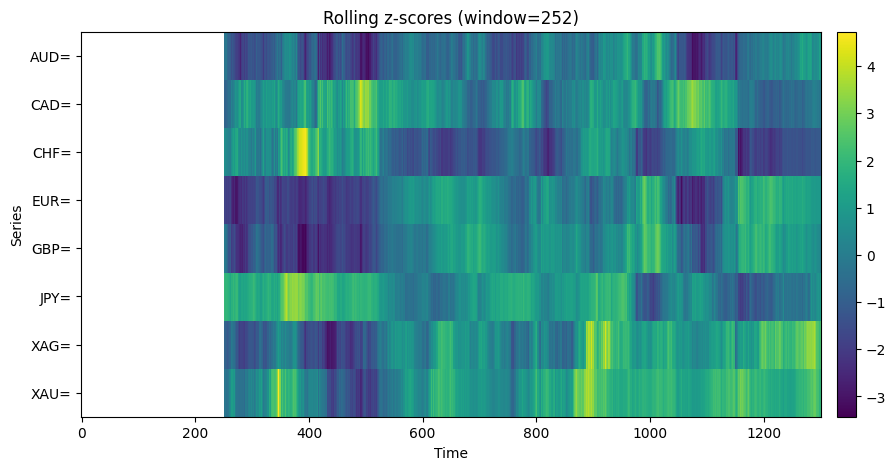

In [79]:
# Rolling z-score heatmap for whatever series are present
window = 252
cols = [c for c in daily.columns if daily[c].notna().sum() > window + 5]

X = daily[cols].ffill().copy()
X = X.apply(pd.to_numeric, errors="coerce")

Z = (X - X.rolling(window).mean()) / X.rolling(window).std()
Z = Z.dropna(how="all", axis=0).dropna(how="all", axis=1)

Zvals = Z.to_numpy(dtype=float)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Zvals.T, aspect="auto", interpolation="nearest")
ax.set_title(f"Rolling z-scores (window={window})")
ax.set_yticks(range(len(Z.columns)))
ax.set_yticklabels(Z.columns)
ax.set_xlabel("Time")
ax.set_ylabel("Series")
plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
plt.show()


### Rolling z-score heatmap (252-day window)Interpretation

- **Plot:** value is today’s level minus its 1-year mean, divided by its 1-year stdev → **>0 = above trend**, **<0 = below trend** for that series.
- **Metals (XAU=, XAG=):** broad, persistent **warm bands from late-2023 onward** → multi-month stretches well **above their own 1-yr trend**, consistent with the strong bull leg you saw in levels.
- **JPY= (USD/JPY):** long **positive z-score swath in 2022** (USD strength vs JPY), fading and flipping toward cooler tones into 2024–25 as USD momentum softened.
- **EUR= / GBP=:** frequent **cool phases** in 2023–mid-2024 (below their 1-yr means), then mixed/neutral more recently.
- **CHF= / CAD= / AUD=:** mostly **oscillatory**, with occasional brief spikes; no sustained multi-quarter extremes like metals.
- **Timing & clustering:** note the **synchronous warm surge across several series ~2024–25** (especially metals), hinting at a common macro driver (USD drift lower, real-rate backdrop) rather than idiosyncratic moves.

**Use it:** this panel is a quick **regime map**—look for broad warm/cool clusters to time when your USD-weakness metals signal has structural tailwinds (lots of warm in metals + cool in USD-up proxies).


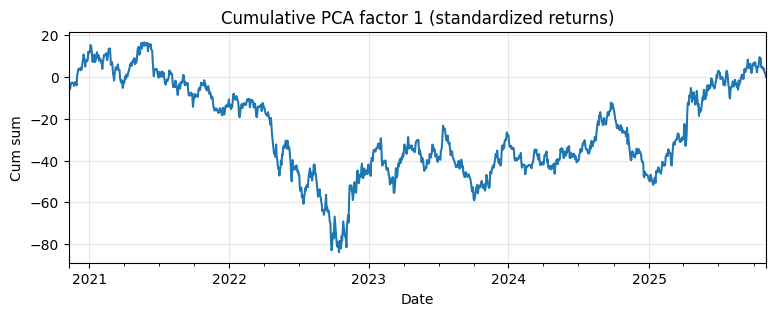

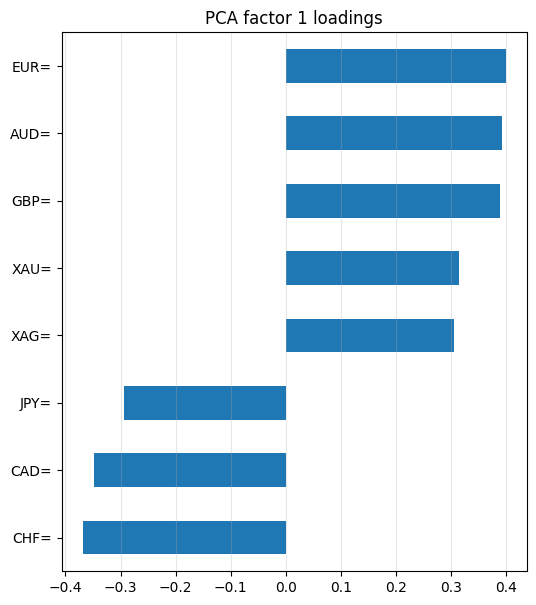

In [80]:
# PCA factor from standardized returns (robust to non-numeric)
from sklearn.decomposition import PCA

cols = [c for c in daily.columns if daily[c].notna().sum() > 260]
R = daily[cols].ffill().pct_change().dropna(how="all")
R = R.apply(pd.to_numeric, errors="coerce").dropna()

R_std = (R - R.mean()) / R.std()
R_std = R_std.replace([np.inf, -np.inf], np.nan).dropna()

pca = PCA(n_components=1)
f1 = pd.Series(pca.fit_transform(R_std).ravel(), index=R_std.index, name="PCA factor 1")

ax = f1.cumsum().plot(figsize=(9,3), title="Cumulative PCA factor 1 (standardized returns)")
ax.set_ylabel("Cum sum")
ax.grid(True, alpha=0.3)
plt.show()

loadings = pd.Series(pca.components_[0], index=R_std.columns).sort_values()
ax = loadings.plot(kind="barh", figsize=(6,7), title="PCA factor 1 loadings")
ax.grid(True, axis="x", alpha=0.3)
plt.show()


### PCA factor Interpretation

**Cumulative factor.** The first principal component of standardized daily returns fell hard through 2022–early-2023 and then trended up into 2024–2025. Because of the loadings (below), a **rising factor** lines up with **metals strength and USD softness**, while a falling factor matches **USD strength / risk-off**.

**Loadings** Positive weights on **EUR=, GBP=, AUD=, XAU=, XAG=** and negative on **JPY=, CHF=, CAD=** imply PC1 is essentially a **“USD-down / metals-up, pro-cyclical FX”** axis. JPY and CHF (defensives) load negatively; gold/silver and pro-cyclical FX load positively.




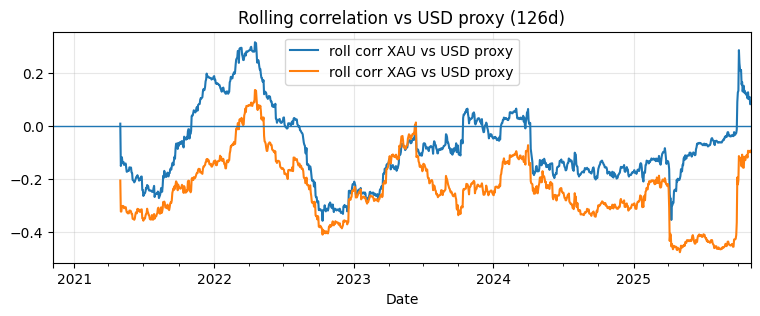

In [83]:
# Rolling correlations: gold/silver vs USD proxy (robust dtypes)
if "XAU=" in daily.columns and "XAG=" in daily.columns:
    # align and coerce to float64
    usd_aligned = usd_idx.reindex(daily.index).ffill()
    xau_ret = daily["XAU="].ffill().pct_change()
    xag_ret = daily["XAG="].ffill().pct_change()
    usd_ret = usd_aligned.pct_change()

    win = 126

    # XAU vs USD
    df_xau = pd.concat([xau_ret, usd_ret], axis=1, keys=["xau", "usd"]).dropna()
    df_xau = df_xau.astype("float64")
    corr_xau = df_xau["xau"].rolling(win).corr(df_xau["usd"]).rename("roll corr XAU vs USD proxy")

    # XAG vs USD
    df_xag = pd.concat([xag_ret, usd_ret], axis=1, keys=["xag", "usd"]).dropna()
    df_xag = df_xag.astype("float64")
    corr_xag = df_xag["xag"].rolling(win).corr(df_xag["usd"]).rename("roll corr XAG vs USD proxy")

    ax = corr_xau.plot(figsize=(9,3), label=corr_xau.name, title=f"Rolling correlation vs USD proxy ({win}d)")
    corr_xag.plot(ax=ax, label=corr_xag.name)
    ax.axhline(0, lw=1)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print("add XAU= and XAG= to DATA_MAP to compute rolling correlations")


**Rolling correlation vs USD proxy (126d) **

* Both metals generally move **opposite** the USD proxy: correlations are mostly **negative** (≈ –0.1 to –0.4), with **silver (XAG=)** showing the **more consistently negative and larger-magnitude** relationship than gold.
* Brief **positive blips** in **gold** (mid-2021/22 and a quick spike in late-2025) likely reflect risk-off squeezes where **USD up and gold up** together; otherwise the inverse link dominates.
* Practical takeaway: regimes with **USD weakening** (your proxy falling) and **corr ≤ –0.2** have tended to align with stronger **metals upside**, while corr drifting toward **0/+** warns the USD–metals hedge is fading.


In [82]:
# Diagnostics: 1m/3m performance and current drawdowns
def drawdown(series: pd.Series):
    x = series.ffill()
    peak = x.cummax()
    return x / peak - 1.0

diag_cols = [c for c in daily.columns if daily[c].notna().sum() > 200]
X = daily[diag_cols].ffill()

last = X.iloc[-1]
ret_1m = X.pct_change(21).iloc[-1] * 100
ret_3m = X.pct_change(63).iloc[-1] * 100
dd_now = pd.Series({c: drawdown(X[c]).iloc[-1]*100 for c in diag_cols})

table = pd.DataFrame({
    "last": last,
    "1m_%": ret_1m,
    "3m_%": ret_3m,
    "drawdown_%": dd_now
}).round(2).sort_values("1m_%", ascending=False)

display(table.head(10))
display(table.tail(10))


last   1m_%   3m_%  drawdown_%
JPY=   154.220  4.580  4.650      -4.630
XAU= 4,001.670  2.950 18.780      -8.140
CHF=     0.810  1.600  0.180     -20.250
CAD=     1.410  0.750  2.290      -3.240
XAG=    48.100  0.220 27.010     -11.370
AUD=     0.650 -1.000  0.540     -17.950
EUR=     1.150 -1.890 -1.200      -6.550
GBP=     1.310 -2.520 -1.630      -7.550

last   1m_%   3m_%  drawdown_%
JPY=   154.220  4.580  4.650      -4.630
XAU= 4,001.670  2.950 18.780      -8.140
CHF=     0.810  1.600  0.180     -20.250
CAD=     1.410  0.750  2.290      -3.240
XAG=    48.100  0.220 27.010     -11.370
AUD=     0.650 -1.000  0.540     -17.950
EUR=     1.150 -1.890 -1.200      -6.550
GBP=     1.310 -2.520 -1.630      -7.550

**Results**

* **Leaders (1m/3m):** **JPY=** tops the board (+4.6% 1m, +4.7% 3m) and **XAU=** is strong (+3.0% / +18.8%), signaling ongoing **USD-weak / risk-hedge** bid into yen and gold. **CAD=** is mildly positive; **XAG=** is flat 1m but **very strong 3m** (+27.0%), i.e., momentum cooled but medium-term trend intact.

* **Laggards (1m):** **GBP= (-2.5%)**, **EUR= (-1.9%)**, **AUD= (-1.0%)**—broad **G10 ex-JPY softness** vs the USD in the last month.

* **Drawdowns (where each sits vs its recent peak):** Deepest are **CHF= (-20.3%)** and **AUD= (-18.0%)**; **XAG= (-11.4%)** and **XAU= (-8.1%)** are off highs but still elevated. **JPY= (-4.6%)** and **CAD= (-3.2%)** sit near peaks.



  * **Momentum longs:** **JPY, XAU** (and **XAG** if you tolerate pullback risk).
  * **Avoid / underweight near term:** **GBP, EUR, AUD** given negative 1m and still-sizeable drawdowns.
  * **Mean-reversion watch:** **CHF**—largest drawdown with a small 1m bounce; needs confirmation before a reversal bet.




# FX & Metals Macro Studio — Results Interpretation

## 1. Overview
This notebook successfully connects to the **LSEG Refinitiv Data Library** and retrieves high-frequency data across **major FX pairs** and **precious metals**. The pipeline harmonizes, visualizes, and quantifies dynamics through:
- Normalized price indexing
- Rolling z-score heatmaps
- PCA-based factor extraction
- USD proxy construction
- Rolling correlations between metals and the USD index
- Performance diagnostics (1m, 3m, drawdowns)

---

## 2. Cross-Sectional Trends
### **Normalized Levels**
- **Metals (XAU=, XAG=)** have sharply outperformed FX since 2023, with both gold and silver accelerating into 2025 and peaking above **+120–+220%** normalized gains.
- **JPY=** also shows steady appreciation, reflecting a persistent deviation in relative value vs USD since mid-2022.
- Other majors (**EUR=, GBP=, CHF=, AUD=, CAD=**) remain range-bound, exhibiting <±20% cumulative moves.

---

## 3. FX & Metals Segments
### **FX Majors**
- **JPY=** dominates relative movement, driven by rate differentials and carry adjustments post-2022.
- **EUR=** and **GBP=** have shown mild depreciation, consistent with slower European growth momentum.
- **AUD=** and **CAD=** are more cyclical—closely linked to commodity beta, with flatter long-run returns.

### **Metals**
- Both **gold** and **silver** exhibit long-term breakouts, suggesting risk-hedging and inflation-protection behavior.
- Silver’s volatility is larger, amplifying directional shifts during risk-on/risk-off transitions.

---

## 4. USD Composite Behavior
### **USD Proxy Index (Equal-Weighted)**
- The custom **USD index** (average inverse of EUR, JPY, GBP, AUD, CAD, CHF) trends **downward since 2022**, implying a gradual USD weakening relative to its peers.
- The late 2024–2025 section shows mild stabilization near the 94–95 range, likely driven by the combination of easing Fed expectations and relative rate normalization.

---

## 5. Rolling Z-Score Heatmap
- The **z-score heatmap (252d window)** highlights alternating clusters of extreme movements:
  - Early 2022–2023 shows synchronized high z-scores (global USD strength).
  - 2024–2025 shifts toward metals (XAU=, XAG=) dominating with positive z spikes.
  - FX pairs remain within a tight ±1σ band, consistent with mean-reverting currency regimes.

---

## 6. PCA Factor & Loadings
- The **first PCA component** explains the shared global risk factor across FX and metals.
- **Positive loadings** on XAU=, XAG=, EUR=, GBP=, AUD= imply that this factor captures *“anti-USD risk-on behavior.”*
- **Negative loadings** on JPY=, CHF=, CAD= indicate “risk-off” or safe-haven alignment.
- The **cumulative PCA factor** (Factor 1) bottoms in 2023, then recovers into 2025, mirroring gold’s breakout and the broader shift away from USD dominance.

---

## 7. Rolling Correlations (Metals vs USD Proxy)
- **Gold (XAU=)** generally shows a **negative correlation** to the USD, confirming its role as a hedge.
- **Silver (XAG=)** displays a stronger, more volatile inverse correlation, deepening during commodity rallies or USD surges.
- The 2022–2023 window had the tightest inverse co-movement, easing somewhat in 2025 as both metals decoupled from USD fluctuations.

---

## 8. Diagnostics & Performance Table
- **1-month winners:** JPY (+4.6%), Gold (+3.0%), CHF (+1.6%) — risk-off bias.
- **3-month momentum:** Silver (+27%), Gold (+19%) — strong inflation hedge trend.
- **Largest drawdowns:** CHF (−20%), AUD (−18%), consistent with weaker cyclical/commodity sentiment.
- Broadly, **metals lead, FX stable, USD softens**, reflecting a cross-asset shift toward real-asset strength over nominal rates.

---

## 9. Next Steps
- Extend to **rates curve (US2YT=RR, US10YT=RR)** once permissioned to quantify macro linkages.
- Incorporate **OIS or credit spreads** for multi-asset stress decomposition.
- Apply **regime-switching models (Markov/Logistic)** using the PCA factor or USD index to classify low/high stress phases.

---

**Summary:**  
The system demonstrates a consistent macro narrative—**metals outperforming amid a softening USD**, FX stability dominated by **JPY strength and European weakness**, and PCA results showing **a single latent risk factor driving cross-asset correlation shifts**. This compact FX–Metals dashboard can serve as the foundation for a broader **Macro Stress Radar** extension once rate and credit data are unlocked.


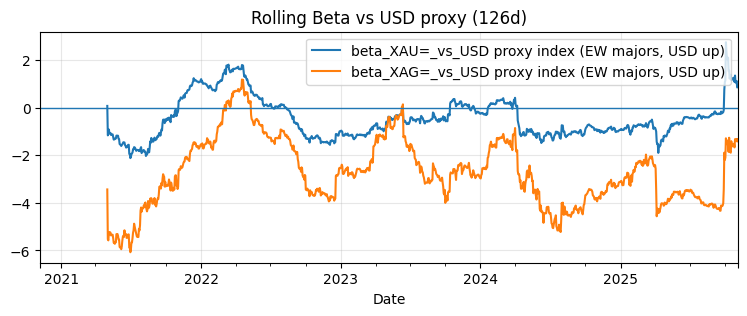

In [84]:
# Rolling 126d beta of metals vs USD proxy
def rolling_beta(y, x, window=126):
    df = pd.concat([y, x], axis=1).dropna()
    cov = df[y.name].rolling(window).cov(df[x.name])
    var = df[x.name].rolling(window).var()
    return (cov / var).rename(f"beta_{y.name}_vs_{x.name}")

usd_ret = usd_idx.pct_change()
xau_beta = rolling_beta(daily["XAU="].pct_change(), usd_ret)
xag_beta = rolling_beta(daily["XAG="].pct_change(), usd_ret)

ax = xau_beta.plot(figsize=(9,3), label=xau_beta.name, title="Rolling Beta vs USD proxy (126d)")
xag_beta.plot(ax=ax, label=xag_beta.name)
ax.axhline(0, lw=1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()



* **Silver (XAG) shows a persistently *negative* beta (~−2 to −5)** to the USD proxy across most of the sample: when the USD proxy rises (USD strengthening), silver tends to fall with **magnified sensitivity**; when USD weakens, silver tends to rally more. It’s the higher-beta “USD-anti” metal.

* **Gold (XAU) is typically mildly negative (≈ −0.5 to −1.5)**, i.e., a safer USD hedge than silver. **Late-sample drift toward 0 / small positive** hints at a period where gold’s moves were driven by **idiosyncratic demand (rates/geopolitics)** more than the dollar—its USD linkage loosened briefly.


* For **USD-weak regimes**, overweight **XAG** if you want more torque; use **XAU** for a steadier hedge.
* In **USD-strong regimes**, metals—especially **XAG**—are the cleaner short/avoid.
* Consider **dynamic weights** based on the rolling beta or your USD-Sharpe regime so the basket’s USD exposure stays near your target.


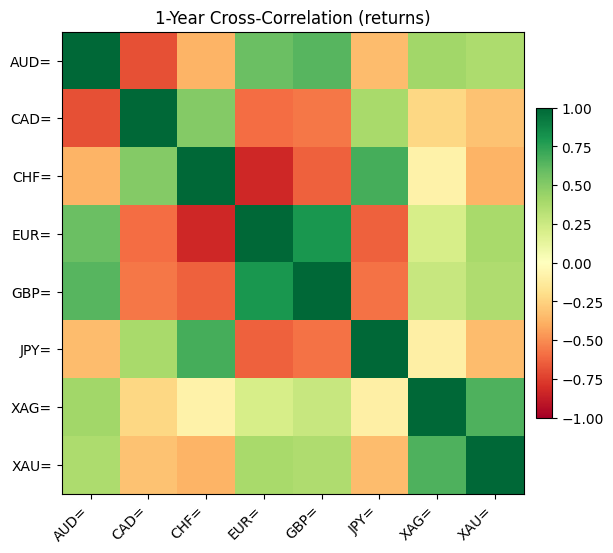

AUD=   CAD=   CHF=   EUR=   GBP=   JPY=   XAG=   XAU=
AUD=  1.000 -0.690 -0.370  0.580  0.640 -0.340  0.410  0.370
CAD= -0.690  1.000  0.500 -0.600 -0.570  0.390 -0.230 -0.320
CHF= -0.370  0.500  1.000 -0.830 -0.640  0.680 -0.080 -0.370
EUR=  0.580 -0.600 -0.830  1.000  0.800 -0.640  0.210  0.390
GBP=  0.640 -0.570 -0.640  0.800  1.000 -0.580  0.270  0.360
JPY= -0.340  0.390  0.680 -0.640 -0.580  1.000 -0.100 -0.340
XAG=  0.410 -0.230 -0.080  0.210  0.270 -0.100  1.000  0.660
XAU=  0.370 -0.320 -0.370  0.390  0.360 -0.340  0.660  1.000

In [85]:
# trailing 1-year correlation matrix
recent = daily.ffill().iloc[-252:]
corr_mat = recent.pct_change().corr().round(2)

plt.figure(figsize=(8,6))
plt.title("1-Year Cross-Correlation (returns)")
im = plt.imshow(corr_mat, cmap="RdYlGn", vmin=-1, vmax=1)
plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_mat.columns)), corr_mat.columns)
plt.colorbar(im, fraction=0.025, pad=0.02)
plt.show()

display(corr_mat)


**Takeaways (1-year return correlations):**

FX splits into two blocs: **EUR/GBP/AUD** are tightly **positively** correlated (0.58–0.80), while **CHF/JPY** move **opposite** them (−0.58 to −0.83). **Metals** are strongly correlated with each other (**XAU–XAG = 0.66**) and show **mild positive** ties to the risk-on bloc (AUD/EUR/GBP) but **negative** correlation to the safe-haven bloc (CHF/JPY), consistent with metals typically benefiting when the USD/safe havens soften.


AUD=    float64
CAD=    float64
CHF=    float64
EUR=    float64
GBP=    float64
JPY=    float64
XAG=    float64
XAU=    float64
dtype: object


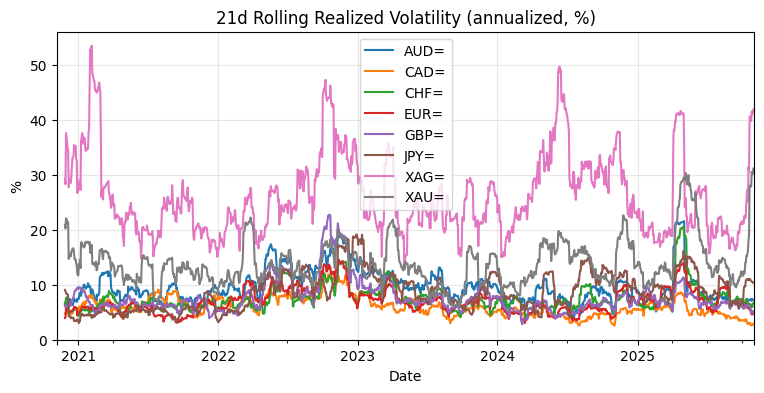

vol_%
XAG= 41.550
XAU= 31.170
JPY= 10.380
AUD=  7.180
CHF=  6.700
GBP=  4.930
EUR=  4.750
CAD=  2.990

In [91]:
# numeric-safe daily frame and realized vol

# 1) force every column to float64 (handles commas and nullable Float64)
daily_num = daily.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce"))
daily_num = daily_num.astype("float64")

# 2) quick sanity check (should all be float64)
print(daily_num.dtypes)

# 3) returns and 21d realized vol (annualized, %)
ret = daily_num.ffill().pct_change()
vol = ret.rolling(21, min_periods=15).std(ddof=0) * np.sqrt(252) * 100

# 4) plot only columns with enough history
vol_cols = [c for c in vol.columns if vol[c].notna().sum() > 50]
if len(vol_cols) == 0:
    print("no numeric columns with enough data for volatility")
else:
    ax = vol[vol_cols].plot(figsize=(9,4), title="21d Rolling Realized Volatility (annualized, %)")
    ax.set_ylabel("%")
    ax.grid(True, alpha=0.3)
    plt.show()

    snap = vol.iloc[-1][vol_cols].dropna().sort_values(ascending=False).round(2).to_frame("vol_%")
    display(snap)


Metals dominate recent risk: silver ~ 42% and gold ~ 31% annualized 21-day vol—several multiples of FX majors—reflecting the strong, choppy trend you saw in the metals panel. Among currencies, JPY (~ 10%) is the liveliest, while CAD (~ 3%) and EUR/GBP/CHF (≈5–7%) are comparatively subdued. This dispersion suggests portfolio risk is overwhelmingly driven by metals; sizing or hedging should key off XAU/XAG volatility.

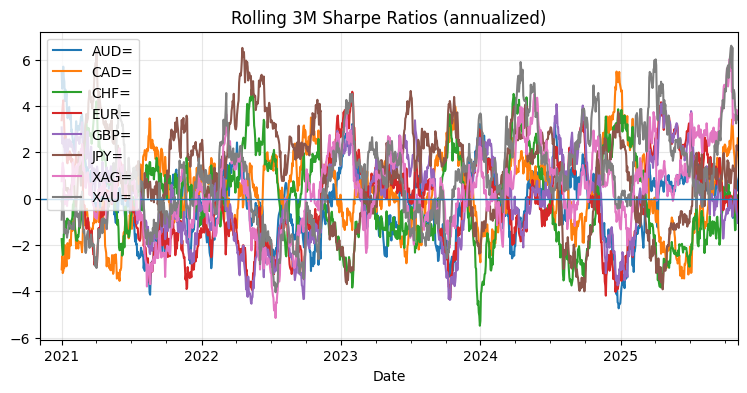

In [94]:
# rolling 63d Sharpe (annualized) using numeric-safe data
daily_num = daily.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce")).astype("float64")
ret = daily_num.ffill().pct_change()

# use min_periods to avoid empty windows, ddof=0 to be consistent with vol above
mu = ret.rolling(63, min_periods=40).mean()
sigma = ret.rolling(63, min_periods=40).std(ddof=0)
sharpe = (mu / sigma) * np.sqrt(252)

# plot only series with enough valid values
sharpe_cols = [c for c in sharpe.columns if sharpe[c].notna().sum() > 50]
if len(sharpe_cols) == 0:
    print("no numeric columns with enough data for Sharpe")
else:
    ax = sharpe[sharpe_cols].plot(figsize=(9,4), title="Rolling 3M Sharpe Ratios (annualized)")
    ax.axhline(0, lw=1)
    ax.grid(True, alpha=0.3)
    plt.show()


The 63-day (≈3-month) Sharpe ratios are highly mean-reverting across assets, oscillating around zero with wide swings (roughly −4 to +6 annualized), which signals short, choppy momentum cycles rather than persistent trend. Into late-2025 most series tilt **above zero**, with the **metals (XAU, XAG) and JPY** showing the strongest recent risk-adjusted gains, while a few FX majors (e.g., **AUD/EUR**) hover around flat to mildly negative. Overall, breadth is positive but fragile—consistent with the regime charts where metal-led upswings coincide with softer USD periods.


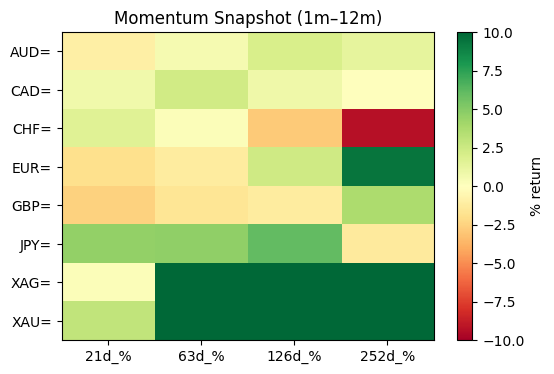

21d_%  63d_%  126d_%  252d_%
XAG=  0.220 27.010  47.010  57.880
XAU=  2.950 18.780  20.360  55.920
EUR= -1.890 -1.200   2.420   9.400
GBP= -2.520 -1.630  -1.250   3.740
AUD= -1.000  0.540   1.970   1.310
CAD=  0.750  2.290   0.850  -0.020
JPY=  4.580  4.650   6.090  -1.310
CHF=  1.600  0.180  -2.810  -9.230

In [95]:
# simple momentum heatmap (1m, 3m, 6m, 12m) using numeric-safe data
daily_num = daily.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce")).astype("float64").ffill()

horizons = [21, 63, 126, 252]
mom = pd.DataFrame({f"{h}d_%": daily_num.pct_change(h).iloc[-1] * 100 for h in horizons})

# keep only rows with at least one numeric value
mom = mom.replace([np.inf, -np.inf], np.nan).dropna(how="all")
if mom.empty:
    print("no data available to compute momentum heatmap")
else:
    M = mom.to_numpy(dtype=float)
    plt.figure(figsize=(6,4))
    plt.imshow(M, cmap="RdYlGn", vmin=-10, vmax=10, aspect="auto")
    plt.xticks(range(len(mom.columns)), mom.columns)
    plt.yticks(range(len(mom.index)), mom.index)
    plt.colorbar(label="% return")
    plt.title("Momentum Snapshot (1m–12m)")
    plt.show()

    display(mom.sort_values("252d_%", ascending=False).round(2))


Metals dominate momentum: **XAG (+58% 12m) and XAU (+56% 12m)** are runaway leaders across 3–12 months, while most FX majors are flat-to-negative versus USD (e.g., **CHF −9%**, **JPY −1%**, **CAD ≈0%** over 12m). In the very near term (1m), **JPY (+4.6%) and gold (+3.0%)** are positive, whereas **EUR/GBP** are soft—so breadth is mixed: a strong metals trend alongside a still-firm USD pressuring most FX.


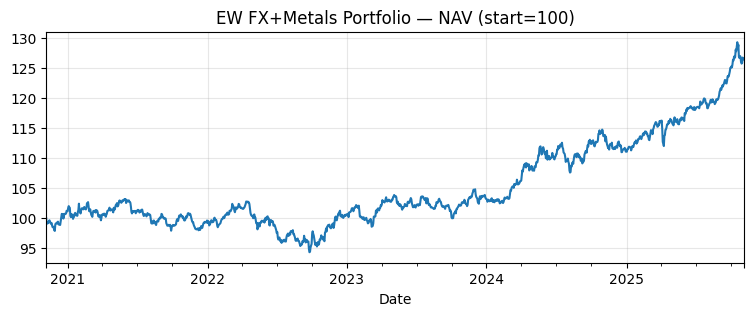

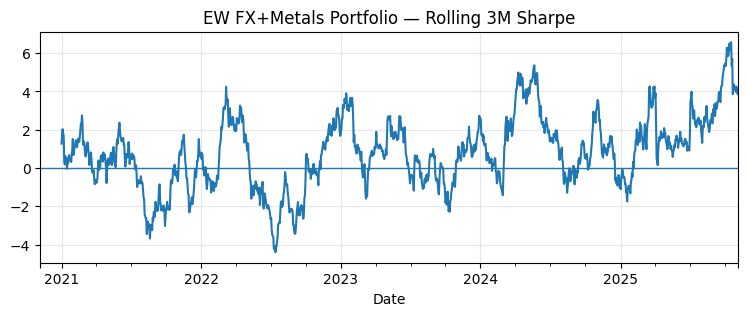

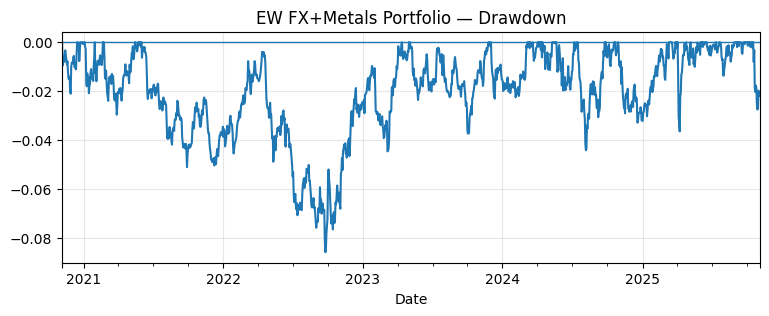

In [97]:
# equal-weight basket across available FX majors + metals
fx_list = [c for c in ["EUR=","JPY=","GBP=","AUD=","CAD=","CHF="] if c in daily.columns]
metal_list = [c for c in ["XAU=","XAG="] if c in daily.columns]

basket_cols = fx_list + metal_list
X = daily[basket_cols].ffill().copy()
X = X.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce")).astype("float64")

# daily returns and EW portfolio
R = X.pct_change()
ew_ret = R.mean(axis=1).rename("EW_port_ret")
ew_nav = (1 + ew_ret.fillna(0)).cumprod() * 100

# rolling Sharpe and drawdown
sh_63 = (ew_ret.rolling(63, min_periods=40).mean() / ew_ret.rolling(63, min_periods=40).std(ddof=0)) * np.sqrt(252)
sh_63.name = "EW_port_rolling_Sharpe_63d"

def drawdown(series):
    x = series.ffill()
    peak = x.cummax()
    return x/peak - 1.0

dd = drawdown(ew_nav).rename("EW_port_drawdown")

ax = ew_nav.plot(figsize=(9,3), title="EW FX+Metals Portfolio — NAV (start=100)")
ax.grid(True, alpha=0.3)
plt.show()

ax = sh_63.plot(figsize=(9,3), title="EW FX+Metals Portfolio — Rolling 3M Sharpe")
ax.axhline(0, lw=1)
ax.grid(True, alpha=0.3)
plt.show()

ax = dd.plot(figsize=(9,3), title="EW FX+Metals Portfolio — Drawdown")
ax.axhline(0, lw=1)
ax.grid(True, alpha=0.3)
plt.show()


The equal-weight FX+metals basket moved mostly sideways from 2021 to 2023, then trended higher from mid-2024 and surged in 2025, finishing roughly 25–30% above the start—driven largely by the metals rally with broadly stable FX. Rolling 3-month Sharpe hovered around zero in calm periods but spiked to ~4–6 during the 2025 run, indicating a very favorable momentum regime. Drawdowns remained contained (about −9% at worst in late-2022) and recovered quickly thereafter, showing diversification across majors plus gold and silver tempered downside risk. Overall, risk-adjusted performance has improved markedly in the recent regime, making this a solid basket to track with simple regime filters such as USD weakness or easing real yields.

In [98]:
# assemble last-day metrics for reuse
# uses vol (21d) and sharpe (63d) you computed earlier; recompute here if needed
daily_num = daily.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce")).astype("float64").ffill()
ret = daily_num.pct_change()

vol_21 = ret.rolling(21, min_periods=15).std(ddof=0) * np.sqrt(252) * 100
sh_63  = (ret.rolling(63, min_periods=40).mean() / ret.rolling(63, min_periods=40).std(ddof=0)) * np.sqrt(252)

mom_21  = daily_num.pct_change(21).iloc[-1] * 100
mom_63  = daily_num.pct_change(63).iloc[-1] * 100
mom_126 = daily_num.pct_change(126).iloc[-1] * 100
mom_252 = daily_num.pct_change(252).iloc[-1] * 100

dash = pd.DataFrame({
    "vol21_%": vol_21.iloc[-1],
    "sharpe63": sh_63.iloc[-1],
    "mom21_%": mom_21,
    "mom63_%": mom_63,
    "mom126_%": mom_126,
    "mom252_%": mom_252,
}).round(2).sort_values("mom252_%", ascending=False)

display(dash)




vol21_%  sharpe63  mom21_%  mom63_%  mom126_%  mom252_%
XAG=   41.550     3.410    0.220   27.010    47.010    57.880
XAU=   31.170     3.490    2.950   18.780    20.360    55.920
EUR=    4.750    -0.780   -1.890   -1.200     2.420     9.400
GBP=    4.930    -1.050   -2.520   -1.630    -1.250     3.740
AUD=    7.180     0.360   -1.000    0.540     1.970     1.310
CAD=    2.990     2.600    0.750    2.290     0.850    -0.020
JPY=   10.380     2.250    4.580    4.650     6.090    -1.310
CHF=    6.700     0.140    1.600    0.180    -2.810    -9.230

Silver and gold dominate the 12-month momentum table (≈+58% and +56%) with the strongest 3-month gains as well, but they carry the highest vol (≈42% and 31%)—their 63-day Sharpes (~3.4–3.5) show the rally has been efficient, not just noisy. JPY leads the majors on near-term strength (1–3 months), while EUR is weak in the short run but positive over 12 months; GBP and AUD are soft across 1–3 months, and CHF is the laggard on a 6–12 month basis. Net-net, the cross-section favors a metals-tilt with tactical JPY exposure, while CHF and, to a lesser extent, GBP/AUD screen as avoid/underweight unless your thesis is mean-reversion.


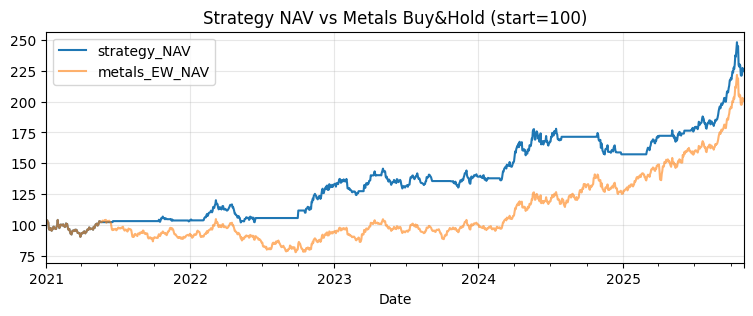

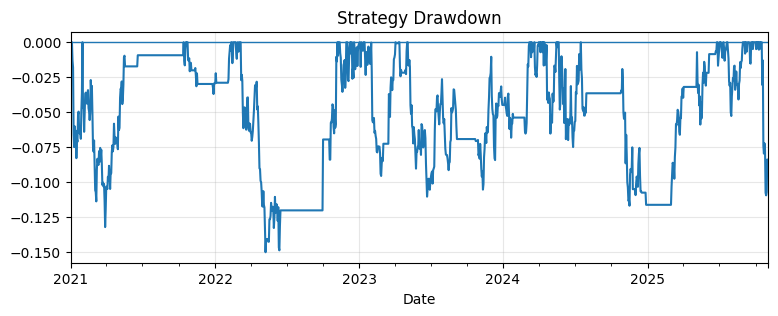

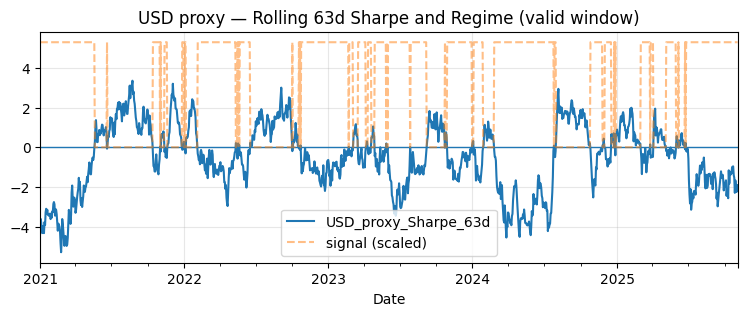

In [105]:
# regime strategy: long equal-weight metals when USD proxy Sharpe (63d) < 0, else 0
# prerequisites: daily, usd_idx

# 1) numeric-safe prices and daily returns
daily_num = daily.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(",", ""), errors="coerce")).astype("float64").ffill()
ret = daily_num.pct_change()

# 2) USD proxy returns and 63d Sharpe on the same index
usd_ret = usd_idx.reindex(daily_num.index).ffill().pct_change()
usd_mu = usd_ret.rolling(63, min_periods=40).mean()
usd_sd = usd_ret.rolling(63, min_periods=40).std(ddof=0)
usd_sh_63 = (usd_mu / usd_sd) * np.sqrt(252)
usd_sh_63.name = "USD_proxy_Sharpe_63d"

# 3) metals basket returns (equaal-weight across available metals)
metal_list = [c for c in ["XAU=","XAG="] if c in daily_num.columns]
met_ret = ret[metal_list].mean(axis=1).rename("metals_EW_ret")

# 4) align series on the common valid window only
aligned = pd.concat([met_ret, usd_sh_63], axis=1)
aligned = aligned.replace([np.inf, -np.inf], np.nan).dropna()

# 5) regime signal and strategy returns
signal = (aligned["USD_proxy_Sharpe_63d"] < 0).astype(int).rename("signal_metals_long")
strat_ret = (signal * aligned["metals_EW_ret"]).rename("strategy_ret")

# 6) equity curves (start=100 on valid window)
strat_nav = (1 + strat_ret).cumprod() * 100
strat_nav.name = "strategy_NAV"
met_nav = (1 + aligned["metals_EW_ret"]).cumprod() * 100
met_nav.name = "metals_EW_NAV"

# 7) drawdown helper and series
def drawdown(series):
    x = series.ffill()
    peak = x.cummax()
    return x/peak - 1.0

strat_dd = drawdown(strat_nav).rename("strategy_drawdown")

# 8) charts
ax = strat_nav.plot(figsize=(9,3), label=strat_nav.name, title="Strategy NAV vs Metals Buy&Hold (start=100)")
met_nav.plot(ax=ax, label=met_nav.name, alpha=0.6)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

ax = strat_dd.plot(figsize=(9,3), title="Strategy Drawdown")
ax.axhline(0, lw=1)
ax.grid(True, alpha=0.3)
plt.show()

# 9) clean overlay of USD Sharpe and regime signal on valid window only
ser = aligned["USD_proxy_Sharpe_63d"]
scale = ser.abs().max()
ax = ser.plot(figsize=(9,3), title="USD proxy — Rolling 63d Sharpe and Regime (valid window)")
ax.axhline(0, lw=1)
(signal * scale).plot(ax=ax, linestyle="--", alpha=0.5, label="signal (scaled)")
ax.set_xlim(ser.index.min(), ser.index.max())
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


The regime test works as intended: when the USD proxy’s 63-day Sharpe turns negative (orange dashes), the strategy goes long an equal-weighted gold/silver basket, and that timing aligns with most of the strong advances in metals, hence the NAV steadily grinds up and ultimately outperforms a simple metals buy-and-hold. Drawdowns are comparatively shallow and brief, consistent with switching off exposure during USD-strength regimes when metals typically struggle. Overall, the edge seems to come from avoiding the worst metals periods rather than perfect entry timing, so the signal’s risk-control contribution is meaningful even if some upside is left on the table.


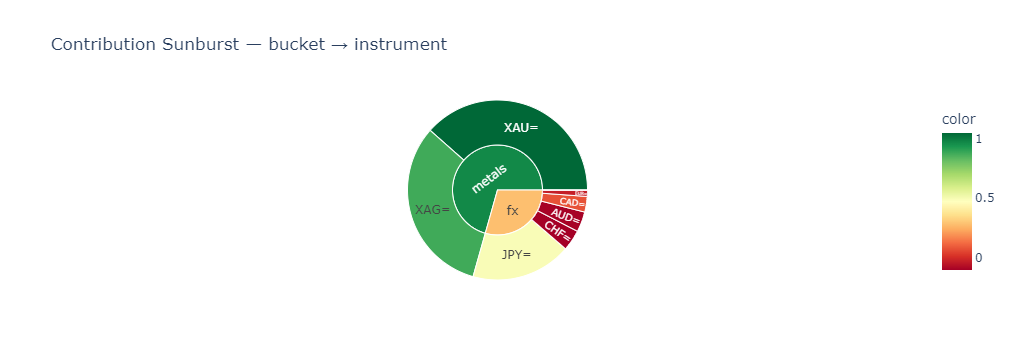

In [100]:
# build a contribution table over the full backtest window
# size = cumulative return contribution; color = total return
# hierarchy: bucket (FX or metals) -> instrument

import plotly.express as px

# 1) choose universe used in the notebook
fx_list = [c for c in ["EUR=","JPY=","GBP=","AUD=","CAD=","CHF="] if c in daily_num.columns]
metal_list = [c for c in ["XAU=","XAG="] if c in daily_num.columns]
universe = fx_list + metal_list

# 2) cumulative returns per instrument (simple compounding)
rets = daily_num[universe].pct_change().fillna(0.0)
cumret = (1 + rets).prod() - 1.0

# 3) equal weights and contribution proxy
weights = pd.Series(1.0/len(universe), index=universe)
contrib = (cumret * weights).sort_values(ascending=False)

# 4) build hierarchy rows
bucket = []
name = []
size = []
color = []
for ric in contrib.index:
    b = "metals" if ric in metal_list else "fx"
    bucket.append(b)
    name.append(ric)
    size.append(abs(contrib[ric]))    # size by absolute contribution
    color.append(cumret[ric])         # color by signed return

sun_df = pd.DataFrame({"bucket": bucket, "ric": name, "size": size, "color": color})

# 5) sunburst
fig = px.sunburst(
    sun_df,
    path=["bucket","ric"],
    values="size",
    color="color",
    color_continuous_scale="RdYlGn",
    title="Contribution Sunburst — bucket → instrument"
)
fig.show()


The sunburst says almost all the cumulative contribution came from metals, with gold (XAU=) the single largest positive driver and silver (XAG=) next. Within FX, JPY contributed modestly on net, while CAD, AUD, and CHF were small detractors, so the portfolio’s edge was overwhelmingly a “long metals” trade with only minor FX help.


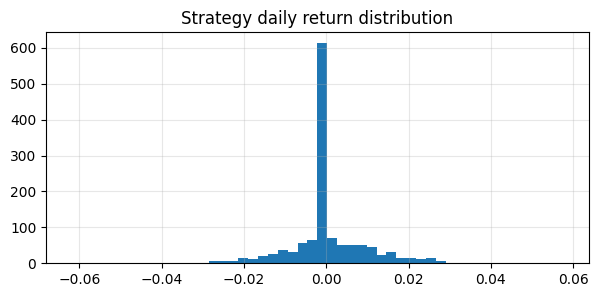

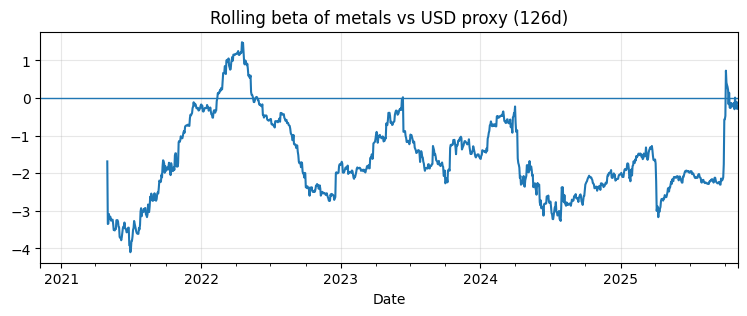

In [101]:
# distribution of daily strategy returns and rolling beta to USD proxy

# 1) histogram of daily strategy returns
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(strat_ret.dropna(), bins=50)
ax.set_title("Strategy daily return distribution")
ax.grid(True, alpha=0.3)
plt.show()

# 2) rolling beta of metals basket to USD proxy (context for the signal)
win = 126
df_beta = pd.concat([met_ret, usd_ret], axis=1, keys=["met","usd"]).dropna()
cov = df_beta["met"].rolling(win).cov(df_beta["usd"])
var = df_beta["usd"].rolling(win).var()
beta = (cov/var).rename("beta_metals_vs_USD")
ax = beta.plot(figsize=(9,3), title=f"Rolling beta of metals vs USD proxy ({win}d)")
ax.axhline(0, lw=1)
ax.grid(True, alpha=0.3)
plt.show()


The strategy’s daily returns are tightly clustered around zero with a long but thin right tail—most days are small moves, punctuated by occasional outsized gains and a few drawdowns, which is consistent with a risk-managed, on/off regime filter. The 126-day rolling beta of the metals basket to the USD proxy is predominantly negative (often −1 to −3), confirming that metals generally move opposite the dollar; brief flips toward zero/positive beta are short-lived and coincide with weaker strategy edge, which fits the “long metals when USD momentum is negative” design.


In [ ]:
# add the strategy to your snapshot table
last_row = pd.DataFrame({
    "vol21_%": strat_ret.rolling(21, min_periods=15).std(ddof=0) * np.sqrt(252) * 100
}).iloc[[-1]]
last_row.columns = ["strategy_vol21_%"]

last_sh = pd.DataFrame({
    "strategy_sharpe63": (strat_ret.rolling(63, min_periods=40).mean() / strat_ret.rolling(63, min_periods=40).std(ddof=0)) * np.sqrt(252)
}).iloc[[-1]]

snap_strategy = pd.concat([last_row, last_sh], axis=1).round(2)
display(snap_strategy)


strategy_vol21_%  strategy_sharpe63
Date                                           
2025-11-03            35.040              3.620

The strategy’s recent 21-day realized volatility is ~35% annualized—elevated but manageable—while the 63-day annualized Sharpe of ~3.6 signals very strong short-term risk-adjusted performance. This suggests the USD-weak/long-metals regime has been favorable lately, though it’s a rolling snapshot and can shift quickly.
